[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClaireZixiWang/robustness-interpretability/blob/main/Robustness_Interpretability_MNIST_Final.ipynb)

# 0. Prerequisites

In [ ]:
!pip install torchattacks

     |████████████████████████████████| 102 kB 3.9 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [ ]:
import requests
from PIL import Image
from io import BytesIO

import copy
import itertools

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

device(type='cuda', index=0)

In [ ]:
from guided_backprop import get_gradients, save_gradient_images, calculate_score

In [ ]:
# network parameters
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.01

In [ ]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
test_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE)

In [ ]:
# class LeNet(nn.Module):
#     def __init__(self):
#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5, padding=2),
#         self.act1 = nn.ReLU(),
#         self.avp1 = nn.AvgPool2d(2, stride=2),
#         self.cov2 = nn.Conv2d(6, 16, 5, padding=0),
#         self.act2 = nn.ReLU(),
#         self.avp2 = nn.AvgPool2d(2, stride=2),
#         self.flatten = nn.Flatten(),
#         self.f1 = nn.Linear(400, 120),
#         self.act3 = nn.ReLU(),
#         self.f2 = nn.Linear(120, 84),
#         self.act4 = nn.ReLU(),

#         self.fc = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.act1(x)
#         x = self.avp1(x) 
#         x = self.cov2(x)
#         x = self.act2(x)
#         x = self.avp2(x)
#         x = self.flatten(x)
#         x = self.f1(x)
#         x = self.act3(x)
#         x = self.f2(x)
#         x = self.act4(x)
#         x = self.fc(x)

#         return x
    
#     def return_first_layer(self, x):
#         x = self.conv1(x)
#         return x

In [ ]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

In [ ]:
# def validate(model, data):
#     total = 0
#     correct = 0
#     for i, (images, labels) in enumerate(data):
#         images = images.cuda()
#         x = model(images)
#         value, pred = torch.max(x,1)
#         pred = pred.data.cpu()
#         total += x.size(0)
#         correct += torch.sum(pred == labels)
#     return correct*100./total


In [ ]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        # accuracy = float(validate(cnn, val_dl))
        # accuracies.append(accuracy)
        # if accuracy > max_accuracy:
        #     best_model = copy.deepcopy(cnn)
        #     max_accuracy = accuracy
        #     print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

In [ ]:
# I have pretrained model, so don't have to run this, can load pretrained model
# but frankly this won't take much time anyways
lenet = train(50, device=device)

In [ ]:
torch.save(lenet.state_dict(), "/content/drive/MyDrive/LeNet/lenet-non-val.pth")

# 1. Pre-trained LeNet Model (Naturally trained)

## Load pre-trained model

In [ ]:
lenet = create_lenet().to(device)
lenet.load_state_dict(torch.load("/content/drive/MyDrive/LeNet/lenet-non-val.pth"))
lenet.eval()

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

## Map of natural datapoints

In [ ]:
map_data_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=1, 
                                          shuffle=False)

Change the number in `itertools.islice()` to select different images. Because the code for guided backpropagation modifies some configurations of the model, you need to reload lenet model if you want to run the below experiment again with different images.

(1, 1, 28, 28)


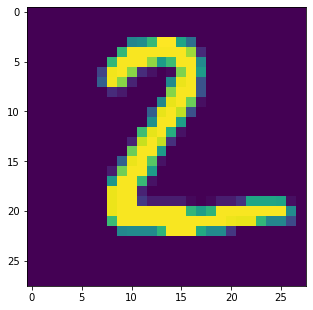

In [ ]:
image, labels = next(itertools.islice(map_data_loader, 1, None))
npimg = image.numpy()
print(npimg.shape)
fig = plt.figure(figsize = (5, 15))
plt.imshow(npimg.reshape(28,28))
# plt.title('title')
plt.show()

In [ ]:
# Set the device for the image
image = image.to(device)
# Set the requires_grad_ to the image for retrieving gradients
image.requires_grad_()


tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.4549, 0.4902, 0.6706, 1.0000, 1.0000, 0.5882,
           0.3647, 0.0000, 0.0000, 0.0000, 

In [ ]:
# Retrieve output from the image
output = lenet(image)

# Catch the output
output_idx = output.argmax()
output_max = output[0, output_idx]

# Do backpropagation to get the derivative of the output based on the image
output_max.backward()

_, predicted = torch.max(output.data, 1)
predicted

tensor([2], device='cuda:0')

In [ ]:
guided_grads = get_gradients(lenet.cpu(), image.cpu(), labels)
guided_grads = np.abs(guided_grads)
calculate_score(image.cpu().detach(), guided_grads)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


63.86181

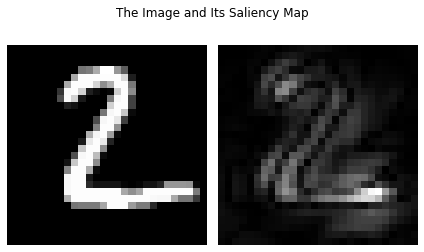

In [ ]:
# Retireve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
# saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
# saliency = saliency.reshape(32, 32)

# Reshape the image
# image = image.reshape(-1, 32, 32)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.cpu().detach().numpy().reshape(28,28), cmap='gray')
ax[0].axis('off')
ax[1].imshow(guided_grads.reshape(28,28), cmap='gray')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()

In [ ]:
save_gradient_images(guided_grads, 'natural-origin-2')

## Robustness of Natural LeNet

In [ ]:
lenet = lenet.to(device)

In [ ]:
from torchattacks import PGD, FGSM

In [ ]:
# model.eval()

correct = 0
total = 0

fgsm = FGSM(lenet, eps=0.3)

for images, labels in test_loader:
    
    images = fgsm(images, labels).cuda()
    outputs = lenet(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Robust accuracy under FGSM attack: %.2f %%' % (100 * float(correct) / total))

Robust accuracy under FGSM attack: 12.69 %


In [ ]:
# model.eval()

correct = 0
total = 0

pgd = PGD(lenet, eps=0.3, alpha=0.1, steps=7)


for images, labels in test_loader:
    
    images = pgd(images, labels).cuda()
    outputs = lenet(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Robust accuracy under PGD attack: %.2f %%' % (100 * float(correct) / total))

Robust accuracy under PGD attack: 0.00 %


## Map of adversaries

### Attack and save adversaries so that we can load and plot images easier later - FGSM

In [ ]:
atk = FGSM(lenet, eps=0.3)
# atk.set_return_type('int') # Save as integer.
atk.save(data_loader=test_loader, save_path="/content/drive/MyDrive/LeNet/mnist10_fgsm.pt", verbose=True)

- Save progress: 100.00 % / Robust accuracy: 12.69 % / L2: 6.20796 (0.004 it/s) 	
- Save complete!


In [ ]:
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
adv_images, adv_labels = torch.load("/content/drive/MyDrive/LeNet/mnist10_fgsm.pt")
adv_data = TensorDataset(adv_images.float()/255, adv_labels)
adv_loader = DataLoader(adv_data, batch_size=1, shuffle=False)

### Plotting!

Change the number in `itertools.islice()` to select different images. Because the code for guided backpropagation modifies some configurations of the model, you need to reload lenet model if you want to run the below experiment again with different images.

(1, 1, 28, 28)


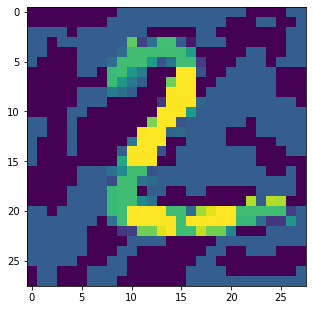

In [ ]:
image, labels = next(itertools.islice(adv_loader, 1, None))
image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
npimg = image.numpy()
print(npimg.shape)
fig = plt.figure(figsize = (5, 15))
plt.imshow(npimg.reshape(28,28))
# plt.title('title')
plt.show()

In [ ]:
# Set the device for the image
image = image.to(device)
# Set the requires_grad_ to the image for retrieving gradients
image.requires_grad_()
# Retrieve output from the image
output = lenet(image)

# Catch the output
output_idx = output.argmax()
output_max = output[0, output_idx]

# Do backpropagation to get the derivative of the output based on the image
output_max.backward()

In [ ]:
_, predicted = torch.max(output.data, 1)
predicted

tensor([0], device='cuda:0')

Wrong prediction on adversaries!

In [ ]:
guided_grads = get_gradients(lenet.cpu(), image.cpu(), labels)
guided_grads = np.abs(guided_grads)
calculate_score(image.cpu().detach(), guided_grads)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


36.582542

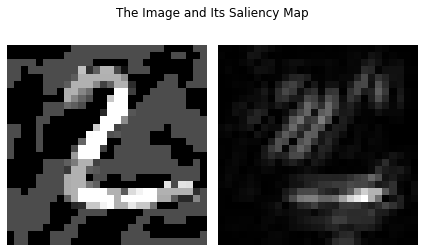

In [ ]:
# Retireve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
# saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
# saliency = saliency.reshape(32, 32)

# Reshape the image
# image = image.reshape(-1, 32, 32)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.cpu().detach().numpy().reshape(28,28), cmap='gray')
ax[0].axis('off')
ax[1].imshow(guided_grads.reshape(28,28), cmap='gray')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()

In [ ]:
save_gradient_images(guided_grads, 'natural-adversarial-2')

# Robust LeNet

## Adverarially train the model using PGD

In [ ]:
mnist_train = torchvision.datasets.MNIST(root='./data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = torchvision.datasets.MNIST(root='./data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

batch_size = 128

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=batch_size,
                                         shuffle=False)

In [ ]:
model = create_lenet().to(device)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
atk = PGD(model, eps=0.3, alpha=0.1, steps=7)


In [ ]:
num_epochs = 50 # Training 50 epochs takes about 10 min

In [ ]:
# I have trained model, load in later cells 
for epoch in range(num_epochs):

    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = atk(batch_images, batch_labels).cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/LeNet/lenet-pgd-trained.pth")

In [ ]:
model = create_lenet().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/LeNet/lenet-pgd-trained.pth"))
model.eval()

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

## Evaluating natural and robust accuracy

### Natural model - Original inputs

In [ ]:
lenet.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = lenet(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Standard accuracy: %.2f %%' % (100 * float(correct) / total))

Standard accuracy: 99.08 %


### Robust model - Original inputs

In [ ]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Standard accuracy: %.2f %%' % (100 * float(correct) / total))

Standard accuracy: 98.51 %


### Robust model - FGSM inputs

In [ ]:
model.eval()

correct = 0
total = 0

fgsm = FGSM(model, eps=0.3)

for images, labels in test_loader:
    
    images = fgsm(images, labels).cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Robust accuracy under FGSM attack: %.2f %%' % (100 * float(correct) / total))

Robust accuracy under FGSM attack: 93.92 %


### Robust model - PGD inputs

In [ ]:
model.eval()

correct = 0
total = 0

pgd = PGD(model, eps=0.3, alpha=0.1, steps=7)

for images, labels in test_loader:
    
    images = pgd(images, labels).cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Robust accuracy under PGD attack: %.2f %%' % (100 * float(correct) / total))

Robust accuracy under PGD attack: 91.64 %


# Saliency maps of Adversarially Trained model

## Map of natural datapoints

Change the number in `itertools.islice()` to select different images. Because the code for guided backpropagation modifies some configurations of the model, you need to reload **robust** model if you want to run the below experiment again with different images.

(1, 1, 28, 28)


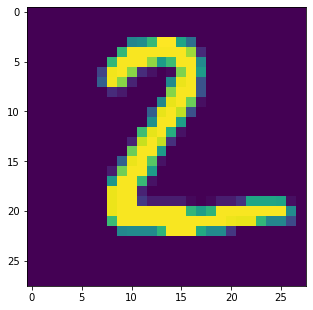

In [ ]:
image, labels = next(itertools.islice(map_data_loader, 1, None))
npimg = image.numpy()
print(npimg.shape)
fig = plt.figure(figsize = (5, 15))
plt.imshow(npimg.reshape(28,28))
# plt.title('title')
plt.show()

In [ ]:
# Set the device for the image
image = image.to(device)
# Set the requires_grad_ to the image for retrieving gradients
image.requires_grad_()


tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.4549, 0.4902, 0.6706, 1.0000, 1.0000, 0.5882,
           0.3647, 0.0000, 0.0000, 0.0000, 

In [ ]:
# Retrieve output from the image
output = model(image)

# Catch the output
output_idx = output.argmax()
output_max = output[0, output_idx]

# Do backpropagation to get the derivative of the output based on the image
output_max.backward()

In [ ]:
_, predicted = torch.max(output.data, 1)
predicted

tensor([2], device='cuda:0')

In [ ]:
guided_grads = get_gradients(model.cpu(), image.cpu(), labels)
guided_grads = np.abs(guided_grads)
calculate_score(image.cpu().detach(), guided_grads)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


15.716099

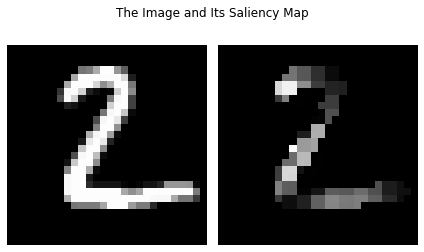

In [ ]:
# Retireve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
# saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
# saliency = saliency.reshape(32, 32)

# Reshape the image
# image = image.reshape(-1, 32, 32)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.cpu().detach().numpy().reshape(28,28), cmap='gray')
ax[0].axis('off')
ax[1].imshow(guided_grads.reshape(28,28), cmap='gray')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()

In [ ]:
save_gradient_images(guided_grads, 'robust-origin-2')

Does stronger adversarially trained model gives a dimmer gradient map?

## Map of adversaries

Change the number in `itertools.islice()` to select different images. Because the code for guided backpropagation modifies some configurations of the model, you need to reload **robust** model if you want to run the below experiment again with different images.

(1, 1, 28, 28)


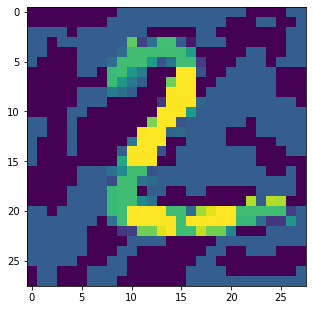

In [ ]:
image, labels = next(itertools.islice(adv_loader, 1, None))
image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
npimg = image.numpy()
print(npimg.shape)
fig = plt.figure(figsize = (5, 15))
plt.imshow(npimg.reshape(28,28))
# plt.title('title')
plt.show()

### Plotting the map

In [ ]:
# Set the device for the image
image = image.to(device)
# Set the requires_grad_ to the image for retrieving gradients
image.requires_grad_()
# Retrieve output from the image
output = model(image)

# Catch the output
output_idx = output.argmax()
output_max = output[0, output_idx]

# Do backpropagation to get the derivative of the output based on the image
output_max.backward()

In [ ]:
_, predicted = torch.max(output.data, 1)
predicted

tensor([2], device='cuda:0')

Correct classification!

In [ ]:
guided_grads = get_gradients(model.cpu(), image.cpu(), labels)
guided_grads = np.abs(guided_grads)
calculate_score(image.cpu().detach(), guided_grads)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


11.835511

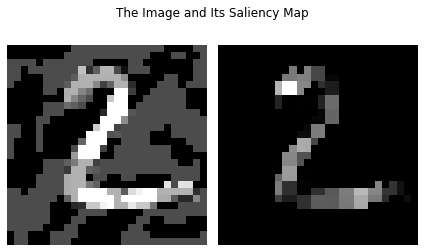

In [ ]:
# Retireve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
# saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
# saliency = saliency.reshape(32, 32)

# Reshape the image
# image = image.reshape(-1, 32, 32)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.cpu().detach().numpy().reshape(28,28), cmap='gray')
ax[0].axis('off')
ax[1].imshow(guided_grads.reshape(28,28), cmap='gray')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()

In [ ]:
save_gradient_images(guided_grads, 'robust-adversarial-2')